In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [2]:
# Testing the dataset 
path_single = r"SatelliteImagery/TrainData/img/image_1500.h5"  #SatelliteImagery/TrainData/img/image_1500.h5
path_single_mask = r'SatelliteImagery/TrainData/mask/mask_1500.h5'   #SatelliteImagery/TrainData/mask/mask_1500.h5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


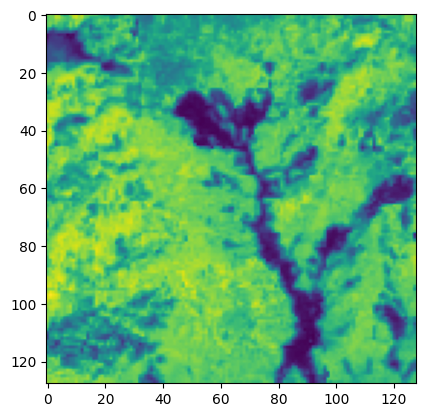

In [3]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)

ls ['mask']
input data shape: (128, 128)


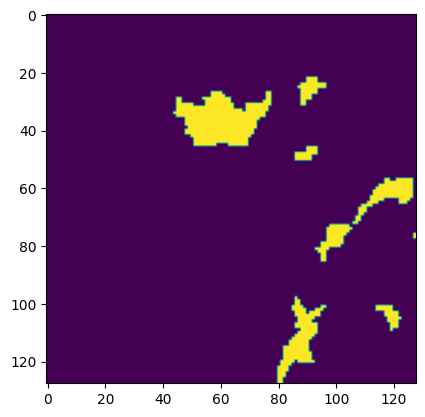

In [4]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [5]:
path_single = r"SatelliteImagery/TrainData/img/image_1500.h5"
path_single_mask = r'SatelliteImagery/TrainData/mask/mask_1500.h5' 
TRAIN_PATH = r"SatelliteImagery/TrainData/img/*.h5"
TRAIN_MASK = r'SatelliteImagery/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [ ]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
    
    
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

In [7]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


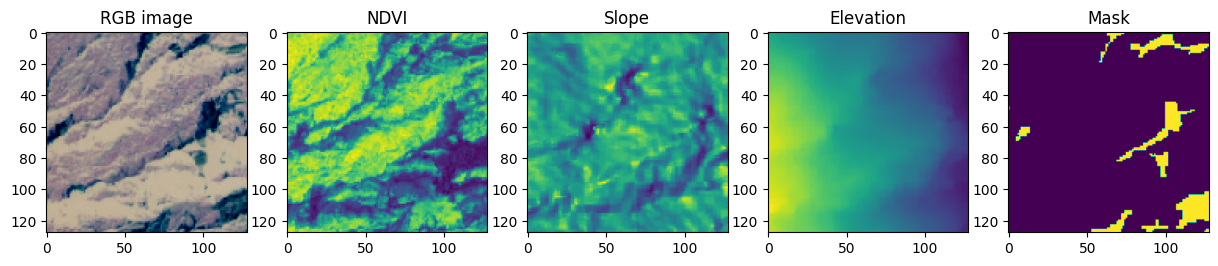

In [8]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

In [9]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


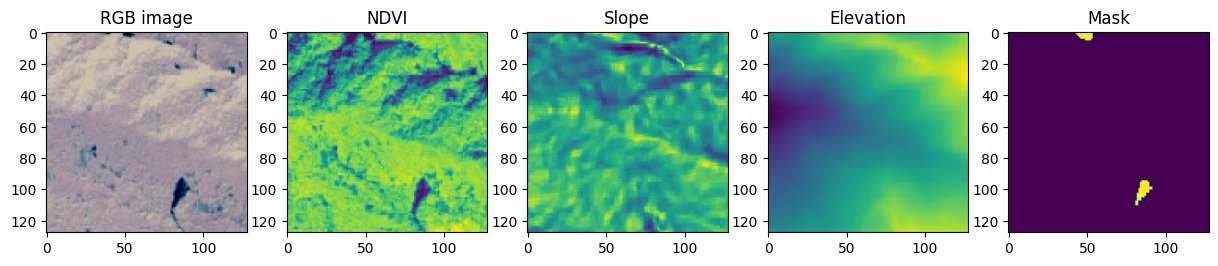

In [10]:
img=1500
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [11]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [12]:
# to release some memory, deleting the unnecessary variable
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


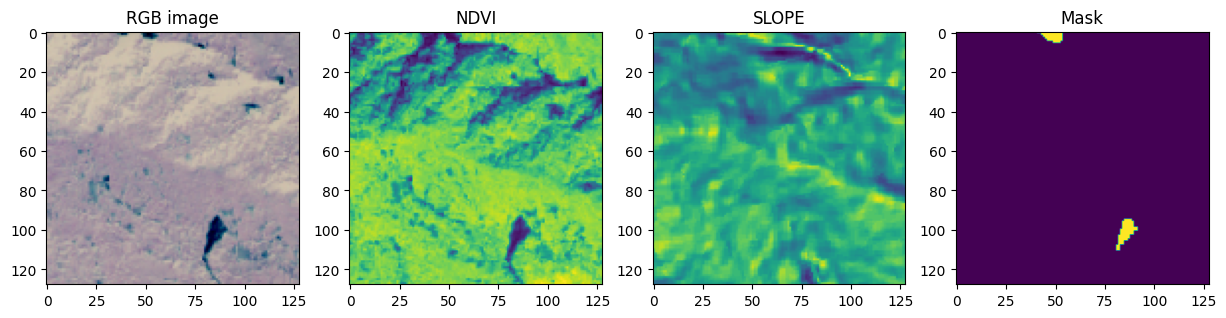

In [13]:
img=1500
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

In [14]:
from utils import recall_m, precision_m, f1_m
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

In [15]:
model = unet_model(128, 128, 6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 6)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         880       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

2024-03-13 20:29:49.960905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 20:29:49.984570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-13 20:29:49.984695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [16]:
history = model.fit(x_train, y_train, batch_size=16,  
          epochs=100,verbose=2,validation_data = (x_valid,y_valid))

Epoch 1/100


2024-03-13 20:30:01.082295: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-13 20:30:01.311194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-13 20:30:01.341061: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 20:30:01.375417: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-13 20:30:03.145850: I external/local_xla/xla/service/service.cc:168] XLA service 0x7633a843c2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 20:30:03.145873: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 La

190/190 - 19s - loss: 0.0812 - accuracy: 0.9729 - f1_m: 0.1305 - precision_m: 0.4374 - recall_m: 0.1014 - val_loss: 0.0453 - val_accuracy: 0.9831 - val_f1_m: 0.6106 - val_precision_m: 0.6985 - val_recall_m: 0.5582 - 19s/epoch - 101ms/step
Epoch 2/100
190/190 - 6s - loss: 0.0435 - accuracy: 0.9837 - f1_m: 0.5623 - precision_m: 0.6985 - recall_m: 0.5005 - val_loss: 0.0414 - val_accuracy: 0.9842 - val_f1_m: 0.6243 - val_precision_m: 0.7355 - val_recall_m: 0.5541 - 6s/epoch - 29ms/step
Epoch 3/100
190/190 - 6s - loss: 0.0400 - accuracy: 0.9849 - f1_m: 0.5921 - precision_m: 0.7223 - recall_m: 0.5255 - val_loss: 0.0396 - val_accuracy: 0.9846 - val_f1_m: 0.6510 - val_precision_m: 0.7144 - val_recall_m: 0.6083 - 6s/epoch - 29ms/step
Epoch 4/100
190/190 - 6s - loss: 0.0387 - accuracy: 0.9852 - f1_m: 0.5959 - precision_m: 0.7458 - recall_m: 0.5229 - val_loss: 0.0371 - val_accuracy: 0.9859 - val_f1_m: 0.6446 - val_precision_m: 0.8021 - val_recall_m: 0.5482 - 6s/epoch - 29ms/step
Epoch 5/100
190/1

In [17]:
model.evaluate(x_valid, y_valid)

24/24 [==============================] - 3s 67ms/step - loss: 0.0360 - accuracy: 0.9879 - f1_m: 0.7168 - precision_m: 0.8216 - recall_m: 0.6382


[0.03601907938718796,
 0.987917959690094,
 0.7167935371398926,
 0.8215718269348145,
 0.6382412314414978]

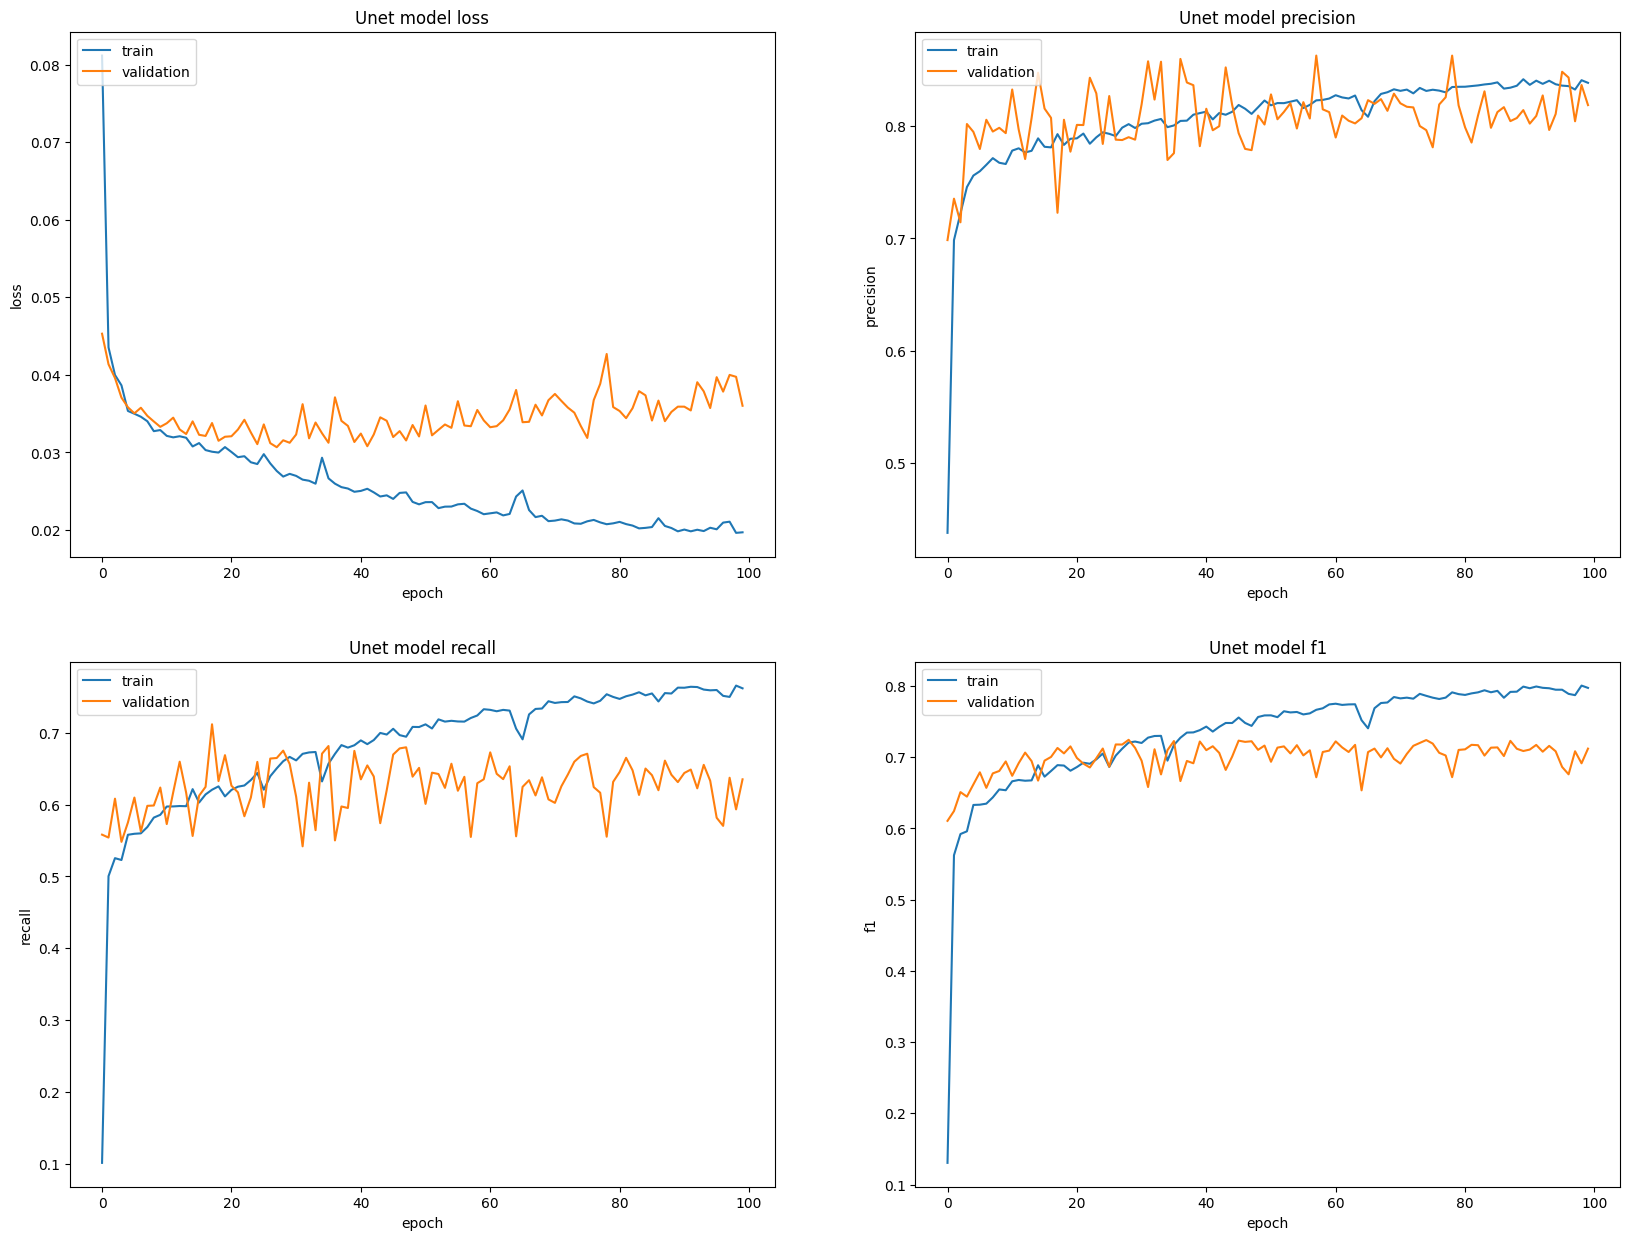

In [18]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [19]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

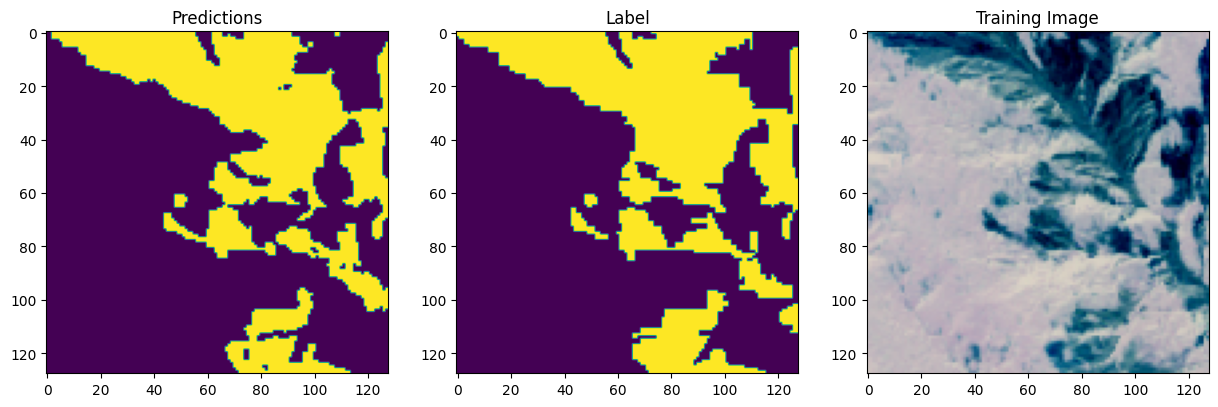

In [20]:
img = 150
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

### Evaluating on test data

In [21]:
test_path = r'SatelliteImagery/TestData/img/*.h5'
img_val = sorted(glob.glob(test_path))

TEST_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    if i == 245:
        break
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        TEST_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        TEST_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TEST_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TEST_XX[i, :, :, 3] = data_ndvi #NDVI
        TEST_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        TEST_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 SatelliteImagery/TestData/img/image_1.h5
1 SatelliteImagery/TestData/img/image_10.h5
2 SatelliteImagery/TestData/img/image_100.h5
3 SatelliteImagery/TestData/img/image_101.h5
4 SatelliteImagery/TestData/img/image_102.h5
5 SatelliteImagery/TestData/img/image_103.h5
6 SatelliteImagery/TestData/img/image_104.h5
7 SatelliteImagery/TestData/img/image_105.h5
8 SatelliteImagery/TestData/img/image_106.h5
9 SatelliteImagery/TestData/img/image_107.h5
10 SatelliteImagery/TestData/img/image_108.h5
11 SatelliteImagery/TestData/img/image_109.h5
12 SatelliteImagery/TestData/img/image_11.h5
13 SatelliteImagery/TestData/img/image_110.h5
14 SatelliteImagery/TestData/img/image_111.h5
15 SatelliteImagery/TestData/img/image_112.h5
16 SatelliteImagery/TestData/img/image_113.h5
17 SatelliteImagery/TestData/img/image_114.h5
18 SatelliteImagery/TestData/img/image_115.h5
19 SatelliteImagery/TestData/img/image_116.h5
20 SatelliteImagery/TestData/img/image_117.h5
21 SatelliteImagery/TestData/img/image_118.h5
22

In [22]:
threshold = 0.5
pred_img = model.predict(TEST_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 [==============================] - 1s 174ms/step


(245, 128, 128, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

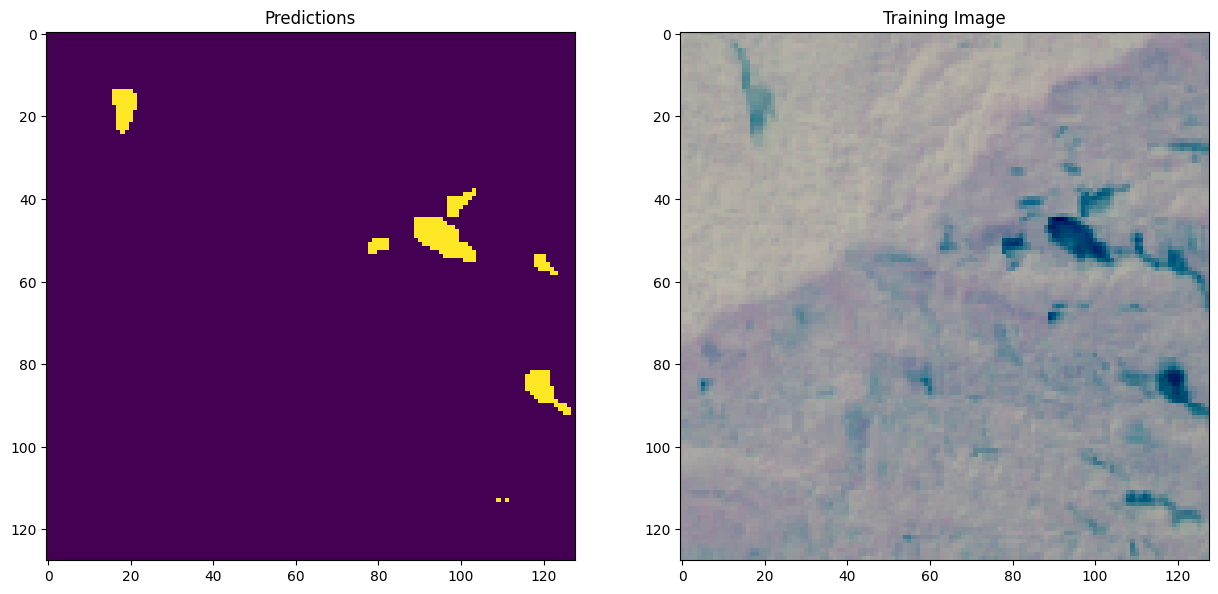

In [23]:
img = 25
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(TEST_XX[img, :, :, 0:3])
ax2.set_title('Training Image')